In [1]:
# make jupyter cells wider

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
from copy import deepcopy

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, cohen_kappa_score, precision_score, recall_score
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib
#matplotlib.style.use('ggplot')
sns.set(font_scale=1.5)

           
% matplotlib inline

In [4]:
df_eda = pd.read_csv('./train_data.csv')
df_eda.shape

(82908, 7)

In [5]:
#random 5 rows from data

df_eda.sample(5)

,user_id,channel,age,os,gender,country,customer
46784,146784,22 Adwords (Search),13,android,male,US,0
35328,135328,69 Others,24,android,male,US,0
11427,111427,22 Adwords (Search),22,android,male,CA,0
41133,141133,12 PINTEREST,33,ios,female,US,1
68383,168383,95 LAT,14,ios,female,AU,0


In [6]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82908 entries, 0 to 82907
Data columns (total 7 columns):
user_id     82908 non-null int64
channel     82908 non-null object
age         82908 non-null int64
os          82908 non-null object
gender      82908 non-null object
country     82908 non-null object
customer    82908 non-null int64
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


no missing values in data

In [7]:
df_eda.describe()

,user_id,age,customer
count,82908.000000,82908.000000,82908.000000
mean,141453.500000,31.151734,0.297848
std,23933.622396,11.596902,0.457315
min,100000.000000,12.000000,0.000000
25%,120726.750000,22.000000,0.000000
50%,141453.500000,29.000000,0.000000
75%,162180.250000,38.000000,1.000000
max,182907.000000,96.000000,1.000000


- Average age is around 30 and conversion rate (from a subscriber to a customer) is 29.8%. It means that base accuracy for our classifier is %70. If a dummy predictor predicts 0 for each value, our accuracy will be 70%. 
- Data is unbalanced I can try over/under sampling to improve performance

# 1) Explanatory Data Analysis

### Age

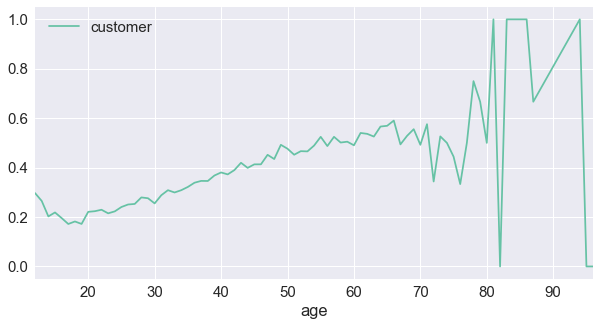

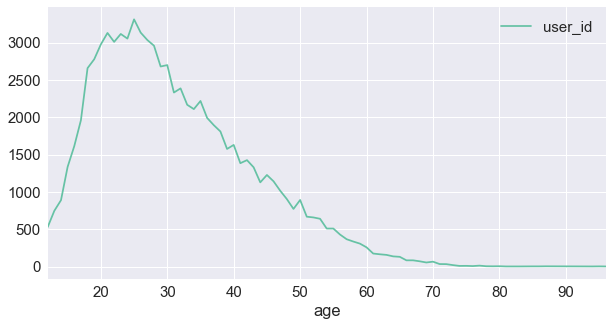

In [8]:
aggfunc = {
    'customer': 'mean',
    'user_id': 'count'
}


pivot1 = df_eda.pivot_table(index='age', values=['customer', 'user_id'], aggfunc=aggfunc).reset_index()
pivot1.plot(x='age', y=['customer'], figsize=(10,5), colormap='Set2')
pivot1.plot(x='age', y=['user_id'], figsize=(10,5), colormap='Set2')

 - After 20, as age increases conversion ratios are rising. It shows that age will be probably important in our model. 
- min age is 12 and max is 96.
- Since conversion is increasing with age, it is better to keep age in the model as the numerical value (instead of creating age buckets). However, I will generate age buckets for visualisation purposes.
- between ages 12-18 there is a different trend, so it is better to group (18-) as a single bucket
- I don't have much data after 65 and because of this conversion rates are fluctuating. It is better to group 65+ ages as a single bucket.
- for the rest, I will use buckets same with google analytics 18-24, 25-34, 35-44, 45-54, 55-64, 65+

In [9]:
def get_age_bucket(age):
    if age <= 18:
        return '12-18'
    elif 18 < age <= 24:
        return '18-24'
    elif 25 <= age <= 34:
        return '25-34'
    elif 35 <= age <= 44:
        return '35-44'
    elif 45 <= age <= 54:
        return '45-54'
    elif 55 <= age <= 64:
        return '55-64'
    elif 65 <= age:
        return '65+'
    else:
        print('!! check this function !!')
        return 'other'
    
df_eda['age_bucket'] = df_eda['age'].apply(lambda x: get_age_bucket(x))
df_eda['age_bucket'].value_counts()

25-34    26823
18-24    18069
35-44    16391
12-18     9735
45-54     8428
55-64     2833
65+        629
Name: age_bucket, dtype: int64

In [10]:
# single function to visualize feature counts and relationship with conversion

def visualize_feature(df, feature):
    if df_eda[feature].nunique() > 4:
        figsize = (10, 5)
    else:
        figsize = (8, 3)
        
    if feature in ['age_bucket']:
        kind = 'bar'
    else:
        kind = 'barh'
        
    sort_column = feature    
    if feature in ['channel']:
        sort_column = 'customer'
            
    print('%s ordered by conversion' %feature)
    p = df_eda.pivot_table(index=feature, values='customer', aggfunc={'customer': ['count', 'mean']}).reset_index()
    p['count%'] = p['count'] / p['count'].sum()
    p = p[[feature, 'count', 'count%', 'mean']]
    p.rename(index=str, columns={'mean': 'conversion'}, inplace=True)
    display(p.round({'count%': 3, 'conversion': 3}).sort_values(by='conversion', ascending=False))
    
    pivot_count = df.pivot_table(index=feature, values='customer', aggfunc='count').reset_index().sort_values(by=sort_column, ascending=True)
    pivot_mean = df.pivot_table(index=feature, values='customer', aggfunc='mean').reset_index().sort_values(by=sort_column, ascending=True)
    ax = pivot_count.plot(x=feature, y='customer', kind=kind, figsize=figsize, colormap='Set2', title='Subscriber Count by %s' %feature, legend=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()
    ax = pivot_mean.plot(x=feature, y='customer', kind=kind, figsize=figsize, colormap='Set2', title = 'Conversion by %s' %feature, legend=False)
    print('\n')
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()

### Age Buckets

- older ages have more conversion ratios
- most users are from 25-34
- age is an important factor

age_bucket ordered by conversion


,age_bucket,count,count%,conversion
6,65+,629,0.008,0.533
5,55-64,2833,0.034,0.515
4,45-54,8428,0.102,0.450
3,35-44,16391,0.198,0.363
2,25-34,26823,0.324,0.273
1,18-24,18069,0.218,0.215
0,12-18,9735,0.117,0.202


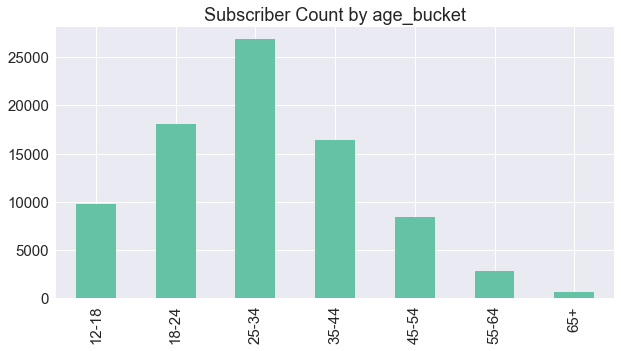

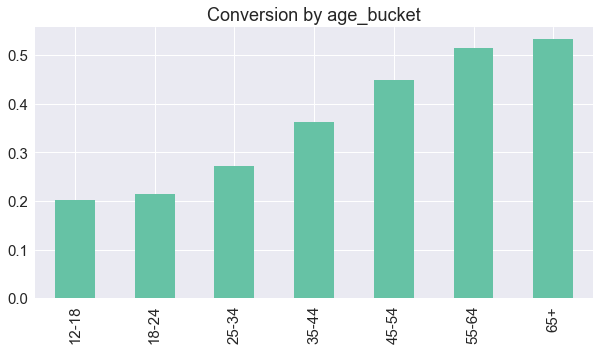

In [11]:
visualize_feature(df_eda, 'age_bucket')

### Operating System
- we have less android users
- iOS users convert more, it is an expected result since iOS products are more expensive in general. The difference is not huge.


os ordered by conversion


,os,count,count%,conversion
1,ios,48662,0.587,0.314
0,android,34246,0.413,0.276


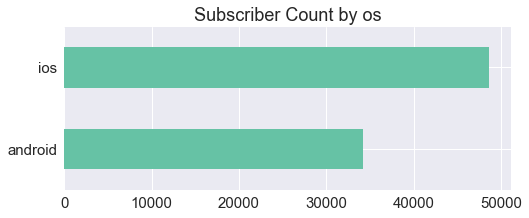

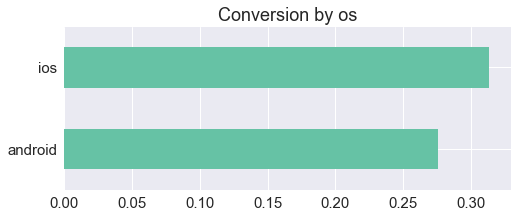

In [13]:
visualize_feature(df_eda, 'os')

### Gender
- we have 2.2 times more female users than male users however male users conversion is slightly higher 

gender ordered by conversion


,gender,count,count%,conversion
1,male,25877,0.312,0.311
0,female,57031,0.688,0.292


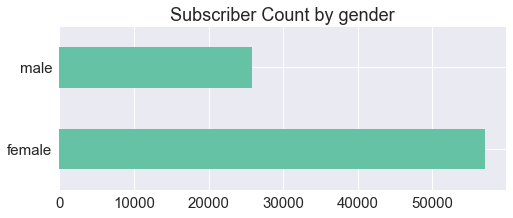

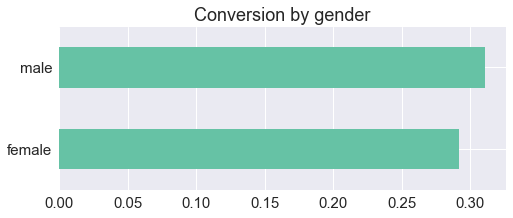

In [14]:
visualize_feature(df_eda, 'gender')

### Country
- majority of our users are from the US
- France has high conversion ratio, but they have the least user count. High conversion rate might be a bias

country ordered by conversion


,country,count,count%,conversion
4,FR,2170,0.026,0.374
0,AU,3398,0.041,0.313
7,US,50855,0.613,0.308
5,GB,9226,0.111,0.296
2,DE,2849,0.034,0.293
1,CA,4483,0.054,0.284
3,ES,4172,0.050,0.267
6,MX,5755,0.069,0.207


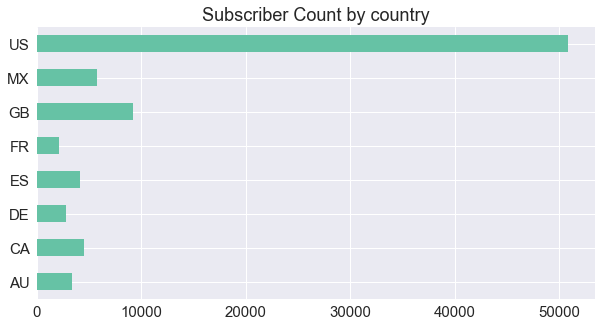

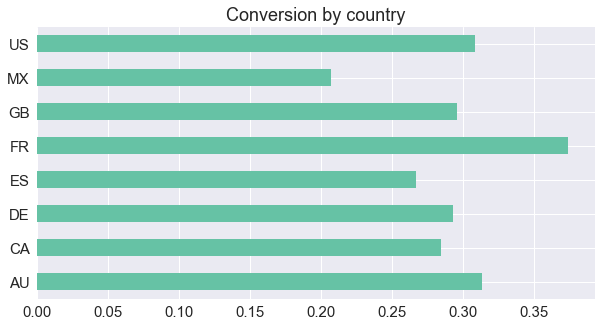

In [16]:
visualize_feature(df_eda, 'country')

### Channel
- Taboola and Outbrain channels outperforming traditional acquisition channels like Google and FB.
- High conversion shows the importance of creating high-quality content


channel ordered by conversion


,channel,count,count%,conversion
6,32 Taboola,2789,0.034,0.457
5,31 OUTBRAIN,6237,0.075,0.426
11,69 Others,876,0.011,0.352
12,95 LAT,7043,0.085,0.333
0,00 Organic,21795,0.263,0.302
2,12 PINTEREST,13564,0.164,0.297
9,61 Web/Content,390,0.005,0.295
3,21 ASA,2108,0.025,0.278
8,42 Adcolony,4806,0.058,0.269
1,11 FB,8857,0.107,0.250


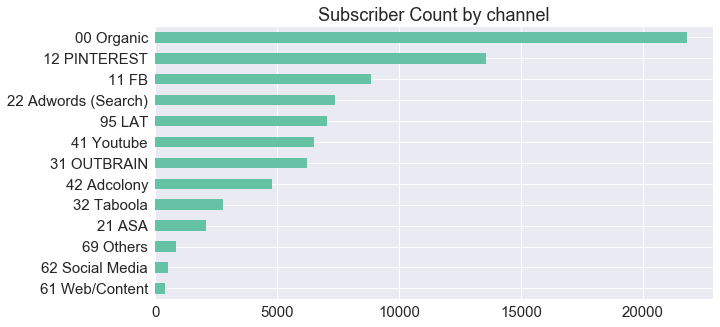

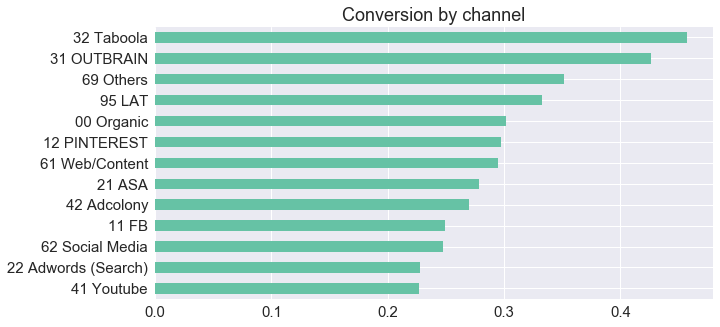

In [18]:
visualize_feature(df_eda, 'channel')

## Statistical Independence of Features vs Conversion
I will make a chi2 test with each feature to test if conversion is independent of it or not. If it is independent, probably It will not be valuable for the prediction model 

In [19]:
df_eda.sample(3)

,user_id,channel,age,os,gender,country,customer,age_bucket
10028,110028,12 PINTEREST,22,ios,female,US,0,18-24
69961,169961,41 Youtube,42,android,male,ES,0,35-44
38325,138325,00 Organic,23,ios,female,AU,1,18-24


In [20]:
for i in df_eda.drop(['user_id', 'customer', 'age'], axis=1).columns:
    p_value = chi2_contingency(df_eda.pivot_table(index='customer', columns=i, values='user_id', aggfunc='count'))[1]
    print(i, p_value)

channel 2.20158709875e-280
os 5.09199835687e-32
gender 6.30382693246e-08
country 2.67837801513e-69
age_bucket 0.0


all p-values are very small (far less than 95% conf level), for all our features we can say that **conversion is not independent** from that it.

# Summary of Explanatory Data Analysis
- Age is an important factor in conversion. In general conversion increases with age
<br><br>
- We have more iOS users than Android (60% vs 40%), conversion is slightly higher for iOS
<br><br>
- We have more Female users than Male (70% vs 30%), conversion is slightly higher for Male
<br><br>
- 60% of users are from the US. France has highest conversion rates (37%) but with lowest users ratio (2.5%)
<br><br>
- Users acquired from Taboola and Outbrain have highest conversion ratios. Most of the users are acquired organically. 
<br><br>
- Age, Gender, Operating System, Country and Channel all these features are important on conversion

-----

# 2) Prediction Model

Steps:
- data wrangling
- train/test split
- over/under sampling on training data
- train different models with default params
- parameter optimization on best model from prev. step
- predictions

In [22]:
# load model again on a different dataframe
df = pd.read_csv('./train_data.csv')
df.sample(5)

,user_id,channel,age,os,gender,country,customer
32772,132772,22 Adwords (Search),23,android,male,US,0
57080,157080,12 PINTEREST,29,android,male,US,0
42919,142919,00 Organic,35,ios,female,US,0
78419,178419,00 Organic,33,android,male,US,0
22178,122178,41 Youtube,38,ios,male,ES,0


In [29]:
# This function will be used both in training and prediction data. It prepares data for 
# machine learning models by doing label encoding, normalisation and one-hot-encoding

def prepare_data(df):
    df_final = deepcopy(df)
     
    # since os and gender have 2 unique values, I will convert them to binary (instead of 2 columns after one-hot-encoding)
    gender_dict = {'male': 1, 'female': 0}
    os_dict = {'ios': 1, 'android': 0}
    df_final['gender'] = df['gender'].apply(lambda x: gender_dict[x])
    df_final['os'] = df['os'].apply(lambda x: os_dict[x])
    
    
    # one hot encoding for channel and country columns
    for i in ['channel', 'country']:
        if i in df.columns:
            df_final = pd.concat([df_final, pd.get_dummies(df[i], prefix='is')], axis=1) # concat one hot encoding to original df
            df_final.drop([i], axis=1, inplace=True) # drop the original column

            
    # min-max scale age in range of [0,1] --> not critical for decision trees but good for other models 
    scaler = MinMaxScaler()
    df_final['age'] = scaler.fit_transform(pd.DataFrame(df['age']))

    
    # remove user_id, meaningless for prediction model
    df_final.drop(['user_id'], axis=1, inplace=True)
    
    return df_final

In [30]:
X = df.drop(['customer'], axis=1)
y = df['customer']

In [31]:
# I am doing data preparation AFTER train/test split to prevent data leakage. Otherwise, MinMaxScaler results will be different

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2) # create train/test split

X_train = prepare_data(X_train_raw)
X_test = prepare_data(X_test_raw)

X_train.shape, X_test.shape

((66326, 24), (16582, 24))

In [32]:
X_train.sample(5)

,age,os,gender,is_00 Organic,is_11 FB,is_12 PINTEREST,is_21 ASA,is_22 Adwords (Search),is_31 OUTBRAIN,is_32 Taboola,...,is_69 Others,is_95 LAT,is_AU,is_CA,is_DE,is_ES,is_FR,is_GB,is_MX,is_US
26742,0.452381,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
14612,0.142857,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
70515,0.321429,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56442,0.071429,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19454,0.226190,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


### visualize data on 2-dimensional space

Let's apply PCA to visualise our data on the 2-dimensional plot. It might be useful to decide if linear or non-linear models will work better

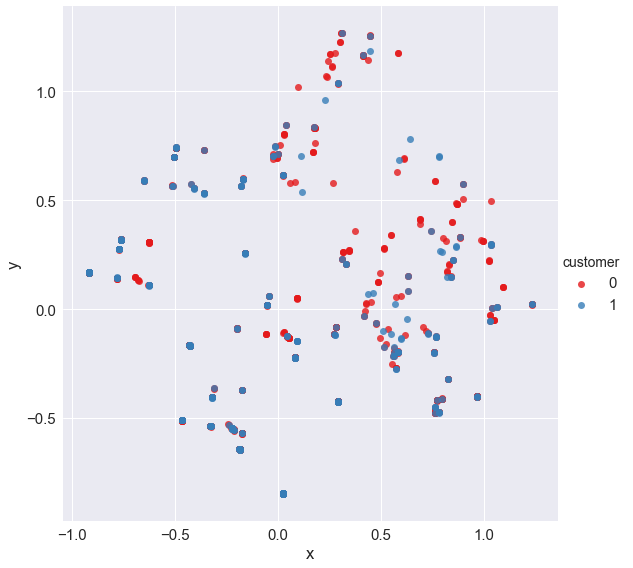

In [33]:
pca = PCA(n_components=2)
pca_data = pd.DataFrame(pca.fit_transform(X_train), columns=['x', 'y'])
pca_data['customer'] = y_train.values
sns.lmplot(x='x', y='y', data=pca_data.sample(1000), fit_reg=False, hue="customer", palette="Set1", size=8)

- It looks like there is no clear distinction between groups (at least when we decrease features to 2). 
- Not an easy classification problem, probably a sign of additional feature requirement and low performance

### Under / Over Sampling

I will generate different training datasets by oversampling and undersampling to compare performances

In [35]:
#oversample with Synthetic Minority Over-sampling Technique (SMOTE)

X_train_os, y_train_os = SMOTE().fit_sample(X_train, y_train)
X_train_os = pd.DataFrame(X_train_os, columns=X_train.columns)
y_train_os.mean()

0.5

In [34]:
#undersample with Random Under Sampling

X_train_us, y_train_us = RandomUnderSampler().fit_sample(X_train, y_train)
X_train_us = pd.DataFrame(X_train_us, columns=X_train.columns)
y_train_us.mean()

0.5

both oversampled and undersampled data has %50 conversion ratio, it shows that our data is balanced now

### Feature Selection
- I will decide important features with Kbest

In [36]:
kbest = SelectKBest(score_func=chi2)
kbest.fit_transform(X_train, y_train)

kbest_scores = pd.DataFrame(X_train.columns, columns=['X'])
kbest_scores['kbest_score'] = kbest.scores_
kbest_scores.sort_values(by='kbest_score', ascending=False, inplace=True)
kbest_scores['ratio'] = round(kbest_scores['kbest_score'] / kbest_scores['kbest_score'].sum(), 2)
kbest_scores['ratio_cumsum'] = kbest_scores['ratio'].cumsum()
kbest_scores.reset_index(drop=True)

,X,kbest_score,ratio,ratio_cumsum
0,is_31 OUTBRAIN,382.002116,0.23,0.23
1,is_32 Taboola,281.788318,0.17,0.40
2,age,213.523455,0.13,0.53
3,is_MX,180.763192,0.11,0.64
4,is_22 Adwords (Search),130.253836,0.08,0.72
5,is_41 Youtube,124.697257,0.08,0.80
6,is_11 FB,88.572763,0.05,0.85
7,is_FR,63.477164,0.04,0.89
8,os,44.867361,0.03,0.92
9,is_95 LAT,34.962770,0.02,0.94


top 14 feature makes 99% cumulative score

In [38]:
# take top 14 features

N = 14
top_n_features = kbest_scores.head(N)['X'].values.tolist()
print(top_n_features)

# function to easily filter top_n features
def apply_feature_selection(X):
    X = X[top_n_features]
    return X

['is_31 OUTBRAIN', 'is_32 Taboola', 'age', 'is_MX', 'is_22 Adwords (Search)', 'is_41 Youtube', 'is_11 FB', 'is_FR', 'os', 'is_95 LAT', 'is_42 Adcolony', 'is_US', 'gender', 'is_ES']


In [39]:
# apply feature selection
X_train_os_fs = apply_feature_selection(X_train_os)
X_train_us_fs = apply_feature_selection(X_train_us)

# I will also need a feature selection applied version of test data (for consistent shapes in training and test)
X_test_fs = apply_feature_selection(X_test)

In [47]:
# final shapes of data frames

df_names = {
    'X_train': {'data': X_train, 'explanation': 'original training data'} ,
    'X_train_os': {'data': X_train_os, 'explanation': 'over-sampled training data'} ,
    'X_train_os_fs': {'data': X_train_os_fs, 'explanation': 'over-sampled and feature selected training data'} ,
    'X_train_us': {'data': X_train_us, 'explanation': 'under-sampled training data'} ,
    'X_train_us_fs': {'data': X_train_us_fs, 'explanation': 'under-sampled and feature selected training data'} ,
    'X_test': {'data': X_test, 'explanation': 'original test data'} ,
    'X_test_fs': {'data': X_test_fs, 'explanation': 'feature selected test data'} ,
}

temp = []
for i in df_names:
    temp.append({
        'data': i,
        'explanation': df_names[i]['explanation'],
        'row_count': df_names[i]['data'].shape[0],
        'feature_count': df_names[i]['data'].shape[1],
    })
    
print('a summary of dataframes generated')
pd.DataFrame(temp)

a summary of dataframes generated


,data,explanation,feature_count,row_count
0,X_train,original training data,24,66326
1,X_train_os,over-sampled training data,24,93150
2,X_train_os_fs,over-sampled and feature selected training data,14,93150
3,X_train_us,under-sampled training data,24,39502
4,X_train_us_fs,under-sampled and feature selected training data,14,39502
5,X_test,original test data,24,16582
6,X_test_fs,feature selected test data,14,16582


In [48]:
# I will try different classifiers with default parameters to compare performances

classifiers = {
    'DummyClassifier': DummyClassifier(strategy='stratified'),
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=20),
    'GradientBoostingClassifier': GradientBoostingClassifier(), 
    'XGBoost': XGBClassifier(),
    'LGBMClassifier': LGBMClassifier(),
    'GaussianNB': GaussianNB(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'MLPClassifier': MLPClassifier(),
    'KNN': KNeighborsClassifier()
}

In [49]:
def fit_and_evaluate(clf_name, train_x, train_y, test_x, test_y):
    clf = classifiers[clf_name]
    clf.fit(train_x, train_y)
    
    # I evaluate models with test data instead of cross validation because cross validation is not suitable for oversampled data.
    y_true = test_y
    y_pred = clf.predict(test_x)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conversion = y_pred.mean()
    return roc_auc, accuracy, f1, conversion

**Now I will try different classifiers with different input sets and decide which works best. **

In [56]:
%%time

df_model_scores = []

for clf_name in classifiers:
    for datatype in ['plain', 'oversample', 'oversample_fs', 'undersample', 'undersample_fs']:
        if datatype == 'plain':
            roc_auc, accuracy, f1, conversion = fit_and_evaluate(clf_name, X_train, y_train, X_test, y_test)
        elif datatype == 'oversample':
            roc_auc, accuracy, f1, conversion = fit_and_evaluate(clf_name, X_train_os, y_train_os, X_test, y_test)
        elif datatype == 'oversample_fs':
            roc_auc, accuracy, f1, conversion = fit_and_evaluate(clf_name, X_train_os_fs, y_train_os, X_test_fs, y_test)
        elif datatype == 'undersample':
            roc_auc, accuracy, f1, conversion = fit_and_evaluate(clf_name, X_train_us, y_train_us, X_test, y_test)
        elif datatype == 'undersample_fs':
            roc_auc, accuracy, f1, conversion = fit_and_evaluate(clf_name, X_train_us_fs, y_train_us, X_test_fs, y_test)
            
        df_model_scores.append({
            'model': clf_name,
            'roc_auc': roc_auc,
            'accuracy': accuracy, 
            'f1': f1,
            'conversion': conversion,
            'datatype': datatype
        })

df_model = pd.DataFrame(df_model_scores)
df_model.sample(5)

CPU times: user 2min 25s, sys: 4.51 s, total: 2min 29s
Wall time: 2min 29s


In [58]:
display(df_model[['f1', 'datatype', 'model']].sort_values(by='f1', ascending=False).head(10))
display(df_model[['roc_auc', 'datatype', 'model']].sort_values(by='roc_auc', ascending=False).head(10))

,f1,datatype,model
41,0.468513,oversample,MLPClassifier
21,0.467613,oversample,XGBoost
17,0.466850,oversample_fs,GradientBoostingClassifier
22,0.466443,oversample_fs,XGBoost
43,0.464887,undersample,MLPClassifier
37,0.464337,oversample_fs,AdaBoostClassifier
16,0.464128,oversample,GradientBoostingClassifier
42,0.463993,oversample_fs,MLPClassifier
36,0.463912,oversample,AdaBoostClassifier
26,0.463415,oversample,LGBMClassifier


,roc_auc,datatype,model
43,0.599315,undersample,MLPClassifier
42,0.598326,oversample_fs,MLPClassifier
8,0.596963,undersample,LogisticRegression
23,0.596898,undersample,XGBoost
9,0.596424,undersample_fs,LogisticRegression
44,0.596399,undersample_fs,MLPClassifier
19,0.596259,undersample_fs,GradientBoostingClassifier
29,0.596032,undersample_fs,LGBMClassifier
18,0.595953,undersample,GradientBoostingClassifier
7,0.595741,oversample_fs,LogisticRegression


Performance is not changing considerably.

**Chosen variables:**

- model: Multi-layer Perceptron Classifier 
- data: under-sampling (similar performance with over-sampling but safe to use cross-validation)
- features: all features

### Grid Search with MLP

In [60]:
%%time

param_grid_MLP = {
    'activation':['relu', 'tanh', 'logistic', 'identity'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid = GridSearchCV(MLPClassifier(), param_grid=param_grid_MLP, scoring='f1')
grid.fit(X_train_us, y_train_us)

CPU times: user 7min 5s, sys: 1min 36s, total: 8min 41s
Wall time: 7min 35s


In [73]:
grid.best_params_, grid.best_score_

({'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'sgd'},
 0.59705834569483407)

In [114]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_learning_rate,param_solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.952412,0.022459,0.597058,0.598003,logistic,constant,sgd,"{'activation': 'logistic', 'learning_rate': 'c...",1,0.512948,0.513644,0.662872,0.662672,0.615357,0.617692,0.302385,0.000072,0.062560,0.062413
2,1.821927,0.018903,0.595000,0.600392,relu,constant,adam,"{'activation': 'relu', 'learning_rate': 'const...",2,0.595523,0.607532,0.610450,0.608599,0.579023,0.585046,0.511927,0.000179,0.012835,0.010860
26,1.834305,0.023450,0.592940,0.592721,logistic,adaptive,adam,"{'activation': 'logistic', 'learning_rate': 'a...",3,0.598366,0.601297,0.587381,0.582118,0.593073,0.594747,0.102479,0.001021,0.004486,0.007960
29,0.794122,0.012847,0.586885,0.589222,identity,constant,adam,"{'activation': 'identity', 'learning_rate': 'c...",4,0.594951,0.599002,0.600678,0.599383,0.565022,0.569281,0.030697,0.001275,0.015634,0.014101
5,2.179529,0.020398,0.583462,0.588519,relu,invscaling,adam,"{'activation': 'relu', 'learning_rate': 'invsc...",5,0.593838,0.603772,0.566453,0.564247,0.590095,0.597537,0.232784,0.000745,0.012124,0.017350


### Model Performance
for final estimation of model performance, test data will be used.

In [133]:
final_model = MLPClassifier(activation = 'logistic', learning_rate= 'constant', solver= 'sgd')

final_model.fit(X_train_us, y_train_us)
y_pred = final_model.predict(X_test)
y_true = y_test

In [115]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.76      0.68      0.72     11639
          1       0.40      0.49      0.44      4943

avg / total       0.65      0.62      0.63     16582



In [116]:
print('f1:', round(f1_score(y_true, y_pred), 2))
print('roc_auc_score:', round(roc_auc_score(y_true, y_pred), 2))
print('accuracy:', round(accuracy_score(y_true, y_pred), 2))
print('real conversion:', round(y_true.mean(), 2))
print('predicted conversion:', round(y_pred.mean(), 2))

f1: 0.44
roc_auc_score: 0.59
accuracy: 0.62
real conversion: 0.3
predicted conversion: 0.37


- The final score of our model is not satisfactory. f1 score is low
- Recall value is probably more essential for us if that is the case we can increase it by changing the thresholds
- To improve model, we should try to collect more features related to users which will help explain conversion behaviour

### List of features that might be helpful to improve the performance of model:
- first session duration
- steps tracking enabled
- profile completion ratio (height, weight etc.)
- workout logged
- meal logged
- weight logged
- number of friends invited
- any friend accepted the invite
- facebook connect

# 3) Predictions

In [135]:
df_test = pd.read_csv('./test_data.csv')
df_test.sample(5)

,user_id,channel,age,os,gender,country
3562,3562,31 OUTBRAIN,25,ios,male,US
1152,1152,31 OUTBRAIN,29,ios,male,US
9469,9469,42 Adcolony,22,android,female,US
209,209,12 PINTEREST,31,android,female,US
5506,5506,11 FB,40,android,male,US


In [136]:
#prepare input data for model. Using whole data to train. No train/test split here

X_us, y_us = RandomUnderSampler().fit_sample(prepare_data(X), y) 
y_us.mean(), X_us.shape

(0.5, (49388, 24))

In [137]:
# create model and train it with all data

final_model = MLPClassifier(activation = 'logistic', learning_rate= 'constant', solver= 'sgd')
final_model.fit(X_us, y_us)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [139]:
f1_score(y_us, final_model.predict(X_us))

0.54335566907715782

In [138]:
predictions = final_model.predict(prepare_data(df_test))

In [148]:
predictions.shape, df_test.shape

((10000,), (10000, 6))

In [146]:
final_file = deepcopy(df_test)
final_file['customer'] = predictions

In [154]:
final_file.head(10)

,user_id,channel,age,os,gender,country,customer
0,0,42 Adcolony,32,android,female,US,0
1,1,12 PINTEREST,27,android,female,US,0
2,2,00 Organic,36,ios,male,GB,1
3,3,42 Adcolony,29,ios,female,US,0
4,4,12 PINTEREST,20,ios,female,CA,0
5,5,00 Organic,47,ios,female,US,1
6,6,00 Organic,27,android,female,CA,0
7,7,22 Adwords (Search),20,android,female,DE,0
8,8,00 Organic,15,ios,female,US,0
9,9,12 PINTEREST,35,ios,female,US,1


In [155]:
final_file.to_csv('./Baran_Toppare_predictions.csv', index=False)